In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

## 1 文字前處理
以daigt-v2-train-dataset做分類檢測(用測試集得到的準確率太高，我拿其他資料檢測該模型，該模型的確有過擬合，所以此資料集的模型暫且只能算參考)

In [20]:
v2 = pd.read_csv('../data/DAIGT V2 Train Dataset.csv')
v2.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\r\n\r\nModern humans today are always o...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\r\n\...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\r\n\r\nDrivers should not be ...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\r\n\r\nThe ...,0,Phones and driving,persuade_corpus,False


In [21]:
# 看看有幾篇文章
print(f"number of posts: {v2.shape[0]}")

# 1 for AI generated, 0 for human
print(f"category: \n{v2['label'].value_counts()}")
print(f"category: \n{v2['source'].value_counts()}")

number of posts: 44868
category: 
label
0    27371
1    17497
Name: count, dtype: int64
category: 
source
persuade_corpus                       25996
mistral7binstruct_v1                   2421
mistral7binstruct_v2                   2421
chat_gpt_moth                          2421
llama2_chat                            2421
kingki19_palm                          1384
train_essays                           1378
llama_70b_v1                           1172
falcon_180b_v1                         1055
darragh_claude_v6                      1000
darragh_claude_v7                      1000
radek_500                               500
NousResearch/Llama-2-7b-chat-hf         400
mistralai/Mistral-7B-Instruct-v0.1      400
cohere-command                          350
palm-text-bison1                        349
radekgpt4                               200
Name: count, dtype: int64


In [22]:
v2.drop(columns=["prompt_name", "source","RDizzl3_seven"], inplace=True)
v2.head(3)

,text,label
0,Phones\r\n\r\nModern humans today are always o...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\r\n\...,0


In [23]:
v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44868 non-null  object
 1   label   44868 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.2+ KB


## 2 分類模型的訓練流程

### 根據7:3的比例切分資料集


In [24]:
data = v2.copy()
X = data["text"]
y = data["label"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

X_train.head()

39535    In today's fast-paced world, the question of w...
29254    The League of Nations, the United Nations, and...
42012    Dear Senator,\r\n\r\nI am writing to discuss a...
8346     The author is very convinceing he didnt just s...
34907    Title: The Pros and Cons of a Four-Day School ...
Name: text, dtype: object

In [25]:
y_train.head()

39535    1
29254    1
42012    1
8346     0
34907    1
Name: label, dtype: int64

In [26]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data['label'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
label
0    61.003388
1    38.996612
Name: proportion, dtype: float64

train percentage :
label
0    61.06282
1    38.93718
Name: proportion, dtype: float64

test percentage :
label
0    60.86472
1    39.13528
Name: proportion, dtype: float64


### 將文章轉為 DTM

#### 依據詞頻 (classic BoW)

In [27]:
# vectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words="english")
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_test = vectorizer.transform(X_test)

# classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(vec_train, y_train)

y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8193
           1       0.98      0.98      0.98      5268

    accuracy                           0.98     13461
   macro avg       0.98      0.98      0.98     13461
weighted avg       0.98      0.98      0.98     13461



準確率太高了，懷疑過擬合。<br>
所以拿另外的資料判定是否為過擬合<br>
拿daigt_magic_generations測驗採用v2資料集的模型，原本準確率0.99降到0.46

In [30]:
daigt_magic_generations =pd.read_csv('../data/DAIGT Magic Generations.csv')
daigt_magic_generations.head()

,text,label,prompt_name,source,RDizzl3_seven,model
0,"Phones & Driving\n\nIn today's society, people...",1,Phones and driving,persuade_finetuned_llamas,False,llama
1,Phones and Driving\n\nThe majority of humans o...,1,Phones and driving,persuade_finetuned_llamas,False,llama
2,Phones & Driving\n\nCell phones have become a ...,1,Phones and driving,persuade_finetuned_llamas,False,llama
3,Phones and Driving\n\nToday the majority of hu...,1,Phones and driving,persuade_finetuned_llamas,False,llama
4,Do you think that drivers should be able to us...,1,Phones and driving,persuade_finetuned_llamas,False,llama


In [31]:
daigt_magic_generations.drop(columns=["prompt_name", "source","RDizzl3_seven", "model"], inplace=True)
daigt_magic_generations.head()

,text,label
0,"Phones & Driving\n\nIn today's society, people...",1
1,Phones and Driving\n\nThe majority of humans o...,1
2,Phones & Driving\n\nCell phones have become a ...,1
3,Phones and Driving\n\nToday the majority of hu...,1
4,Do you think that drivers should be able to us...,1


In [32]:
daigt_magic_generations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8306 entries, 0 to 8305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8306 non-null   object
 1   label   8306 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 129.9+ KB


檢查daigt_magic_generations, v2有無重覆資料

In [33]:
# 合併兩個資料集
combined_df = pd.concat([daigt_magic_generations['text'], v2['text']], axis=0)

# 檢查重複資料
duplicates = combined_df.duplicated().sum()

print(f"共有 {duplicates} 筆重複資料。")

共有 0 筆重複資料。


In [34]:
vec_daigt_magic_generations = vectorizer.transform(daigt_magic_generations['text'])
daigt_magic_generations_pred = clf.predict(vec_daigt_magic_generations)
## Accuracy, Precision, Recall, F1-score
print(classification_report(daigt_magic_generations['label'], daigt_magic_generations_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.46      0.63      8306

    accuracy                           0.46      8306
   macro avg       0.50      0.23      0.31      8306
weighted avg       1.00      0.46      0.63      8306



C:\Users\user\.conda\envs\NatureLanguageAnalyze\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\.conda\envs\NatureLanguageAnalyze\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\.conda\envs\NatureLanguageAnalyze\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

結果accuracy只有0.46，
使用改用v4(daigt-v4-train-dataset)的資料

## 1. 文字前處理

In [35]:
v4 = pd.read_csv('../data/DAIGT V4 Train Dataset.csv')
v4.head()

,text,label,prompt_name,source,RDizzl3_seven,model
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,human
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,human
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,human
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,human
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,human


In [36]:
# 看看有幾篇文章
print(f"number of posts: {v4.shape[0]}")

# 1 for AI generated, 0 for human
print(f"category: \n{v4['label'].value_counts()}")
print(f"category: \n{v4['source'].value_counts()}")

number of posts: 73573
category: 
label
1    46203
0    27370
Name: count, dtype: int64
category: 
source
persuade_corpus                           25995
persuade_finetuned_llamas                  8306
Mistral7B_CME_v7                           4890
llama_falcon_v3_llama_70b                  3500
llama_falcon_v3_falcon_180b                3493
Intel-neural-chat-7b-v3-1_LLMEssays_v1     3309
mistral7binstruct_v2                       2421
chat_gpt_moth                              2421
mistral7binstruct_v1                       2420
llama2_chat                                2418
kingki19_palm                              1384
train_essays                               1378
llama_70b_v1                               1172
falcon_180b_v1                             1043
nima_gpt4                                  1040
darragh_claude_v6                          1000
darragh_claude_v7                          1000
text-davinci-001                            700
text-davinci-003              

In [37]:
v4.drop(columns=["prompt_name", "source","RDizzl3_seven", "model"], inplace=True)
v4.head()

,text,label
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


In [38]:
v4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73573 entries, 0 to 73572
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    73573 non-null  object
 1   label   73573 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


## 2. 分類模型的訓練流程

In [39]:
data = v4.copy()
X = data["text"]
y = data["label"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

X_train.head()

58115    The Facial Action Coding System (FACS) is a gr...
24722    At some place like NASA, when they are buildin...
37298     Do we choose our own character traits or is o...
16196    Dear Principal,\n\nI know you mean well changi...
71085    The author of "The Challenge of Exploring Venu...
Name: text, dtype: object

In [40]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data['label'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
label
1    62.798853
0    37.201147
Name: proportion, dtype: float64

train percentage :
label
1    62.726937
0    37.273063
Name: proportion, dtype: float64

test percentage :
label
1    62.966655
0    37.033345
Name: proportion, dtype: float64


### 依據詞頻 (classic BoW)

In [41]:
# vectorizer
vectorizer = CountVectorizer(max_features=10000, stop_words="english")
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_test = vectorizer.transform(X_test)

# classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(vec_train, y_train)

y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8174
           1       0.97      0.97      0.97     13898

    accuracy                           0.96     22072
   macro avg       0.96      0.96      0.96     22072
weighted avg       0.96      0.96      0.96     22072



準確率還是很高，但正常一點了。

### tfidf檢測

In [42]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      8174
           1       0.97      0.94      0.95     13898

    accuracy                           0.94     22072
   macro avg       0.94      0.94      0.94     22072
weighted avg       0.94      0.94      0.94     22072



使用詞頻計算的結果比較好

### cross validation

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     19196
           1       0.96      0.95      0.96     32305

    accuracy                           0.94     51501
   macro avg       0.94      0.94      0.94     51501
weighted avg       0.94      0.94      0.94     51501



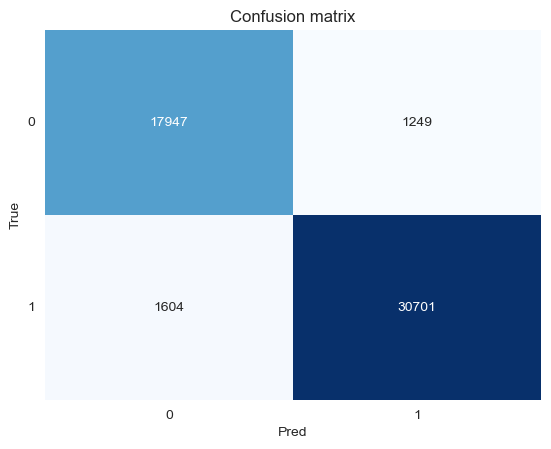

In [43]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可
def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)

    # one-hot encoding
    enc = OneHotEncoder(sparse_output=False)
    enc.fit(y.values.reshape(-1, 1))
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

vectorizer = CountVectorizer(max_features=1000, stop_words="english")
clf = LogisticRegression(max_iter=1000)
result = train_cv(vectorizer, clf, X_train, y_train)

## 3 比較不同模型的效果

LogisticRegression, SVM, DecisionTreeClassifier, RandomForestClassifier

now training: clf_logistic
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     19196
           1       0.96      0.95      0.96     32305

    accuracy                           0.94     51501
   macro avg       0.94      0.94      0.94     51501
weighted avg       0.94      0.94      0.94     51501

now training: clf_dtree
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     19196
           1       0.88      0.88      0.88     32305

    accuracy                           0.85     51501
   macro avg       0.84      0.84      0.84     51501
weighted avg       0.85      0.85      0.85     51501

now training: clf_svm
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     19196
           1       0.98      0.95      0.97     32305

    accuracy                           0.96     51501
   macro avg       0.95      0.96      0.96     51501
w

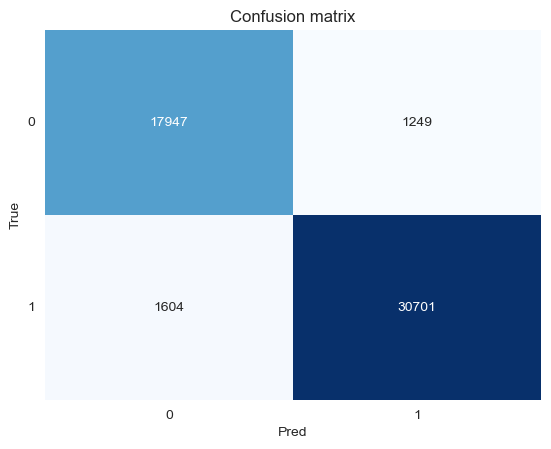

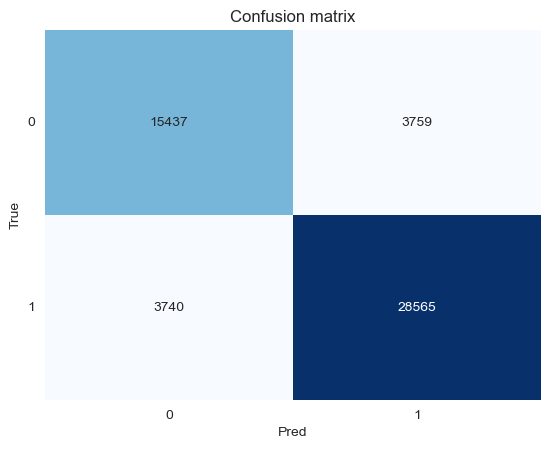

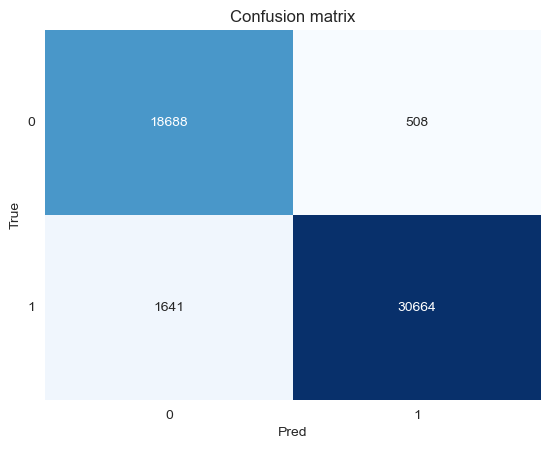

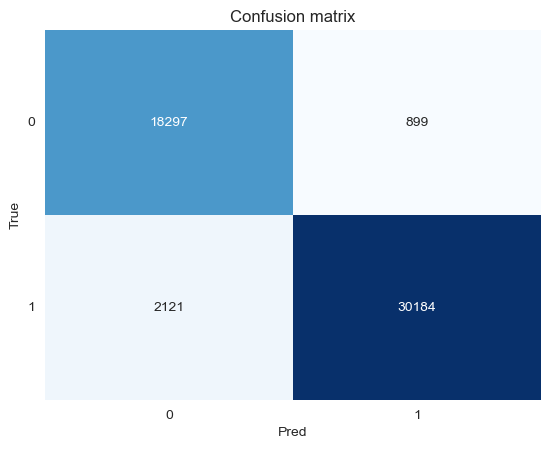

In [44]:
# 準備訓練資料
X = data["text"]
y = data["label"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression(max_iter=1000)
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True)
model_set['clf_rf'] = RandomForestClassifier()

# 定義 vectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words="english")

# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

In [45]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")

best model: clf_svm


logistic regression的準確率(0.95)最高，效果最好。<br>
準確率有達0.95代表LLM和人類生成的文本還很好區別。

In [46]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      8174
           1       0.96      0.95      0.96     13898

    accuracy                           0.95     22072
   macro avg       0.94      0.95      0.94     22072
weighted avg       0.95      0.95      0.95     22072



## 4 分析可解釋模型的結果

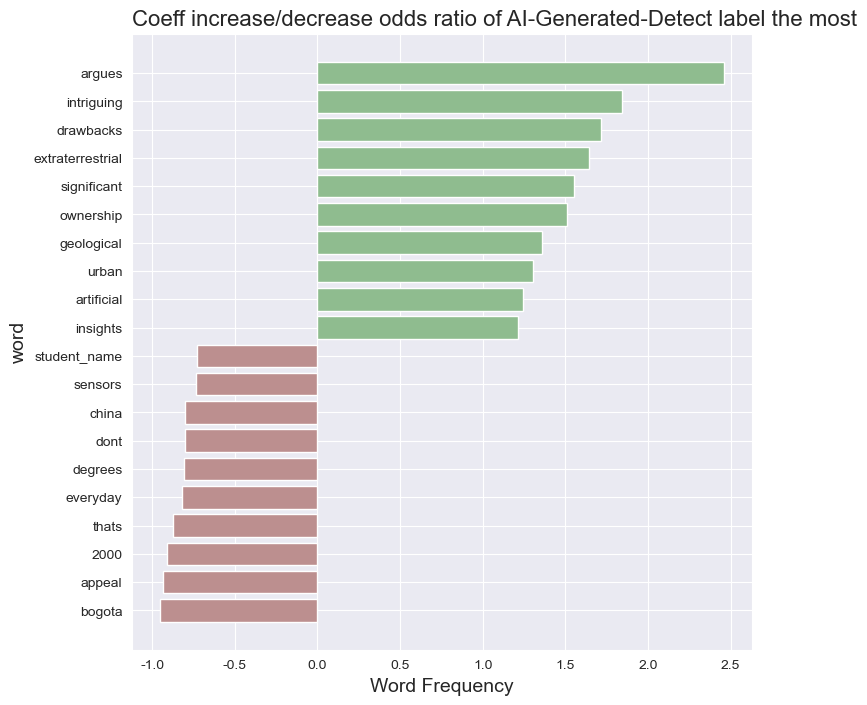

In [47]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_[[1]], index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of AI-Generated-Detect label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

# plot logistic model
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

## 5 結論
LLM的常用詞相較人類生成的文本，像extraterrestrial, ownership都是人類較少或沒有聽過的詞。也就是說LLM用詞會較人類用詞複雜。